In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from __future__ import division
import sys
import os
import pretrainedmodels
sys.path.append('../')
from fastai.vision import *
from modules.basics import *
from fastai.callbacks import *
np.random.seed(0)

# Data import

In [3]:
IMG_PATH = DATA_PATH

In [4]:
train_df = pd.read_csv(IMG_PATH/'train.csv'); len(train_df); train_df.head()

,image_name,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_tau_pz,PRI_met_px,PRI_met_py,PRI_jet_subleading_px,PRI_jet_subleading_py,PRI_jet_subleading_pz,PRI_met_pt,PRI_jet_num,gen_target,gen_weight
0,0,135.817,26.292000,103.488,4.588998,0.0,0.0,0.0,3.080,4.588999,...,49.97136,6.938654,-13.599131,0.0,0.0,0.0,15.266999,0.0,1,0.000337
1,1,190.458,14.596998,141.067,7.952001,0.0,0.0,0.0,3.824,7.952000,...,-199.85202,3.848824,-5.407063,0.0,0.0,0.0,6.636999,0.0,0,0.000180
2,2,109.103,61.177000,76.580,59.290000,0.0,0.0,0.0,3.135,17.427000,...,70.04471,-25.913437,32.415176,0.0,0.0,0.0,41.500000,1.0,1,0.000027
3,3,94.528,77.158000,72.856,64.327000,0.0,0.0,0.0,2.084,16.200000,...,46.16209,-16.587376,24.079796,0.0,0.0,0.0,29.240000,1.0,0,0.000079
4,4,122.040,53.549000,91.318,48.001000,0.0,0.0,0.0,2.283,16.719000,...,32.81852,-11.052309,9.843092,0.0,0.0,0.0,14.800000,1.0,1,0.000337


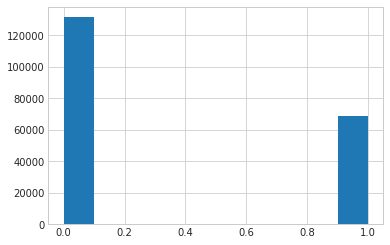

In [5]:
train_df.gen_target.hist()

In [6]:
len(train_df[train_df.gen_target==0])/len(train_df), len(train_df[train_df.gen_target==1])/len(train_df)

(0.65733, 0.34267)

In [7]:
size = 224

In [8]:
data = ImageDataBunch.from_df(df=train_df, label_col='gen_target', fn_col='image_name',
                              bs=20, ds_tfms=None, num_workers=8, valid_pct=0.2,
                              path=IMG_PATH/'images', folder='train', suffix='.png').normalize(imagenet_stats)

In [9]:
data

ImageDataBunch;

Train: LabelList (160000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
1,0,1,0,1
Path: ../data/images;

Valid: LabelList (40000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
1,1,0,0,1
Path: ../data/images;

Test: None

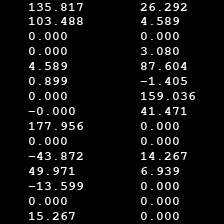

In [10]:
data.train_ds[0][0]

# Model training

In [12]:
def se_resnet154(pretrained=True):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.senet154(pretrained=pretrained)
    return model

In [13]:
learn = cnn_learner(data, se_resnet154, pretrained=True, cut=-3,
                    split_on=lambda m: (m[0][3], m[1]), metrics=error_rate, lin_ftrs=[], bn_final=False, ps=[0]
                )

In [14]:
learn.model

Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu3): ReLU(inplace)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (1): Sequential(
      (0): SEBottleneck(
        (conv1): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_runni

In [15]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


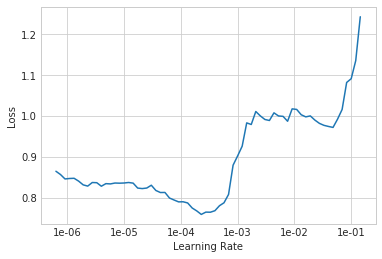

In [16]:
learn.lr_find()
learn.recorder.plot()

In [17]:
learn.fit_one_cycle(8, max_lr=slice(1e-6,2e-4),
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='error_rate', name='best', mode='min')])

epoch,train_loss,valid_loss,error_rate,time
0,0.444102,0.430158,0.195525,1:33:01
1,0.395448,0.398559,0.179800,1:31:55
2,0.406212,0.393738,0.175450,1:31:33
3,0.354600,0.403829,0.179450,1:29:45
4,0.214323,0.537411,0.192900,1:28:45
5,0.043451,0.820141,0.198825,1:28:11
6,0.011598,1.090893,0.192375,1:27:38
7,0.005049,1.077803,0.191775,1:27:34


Better model found at epoch 0 with error_rate value: 0.19552500545978546.
Better model found at epoch 1 with error_rate value: 0.17980000376701355.
Better model found at epoch 2 with error_rate value: 0.17544999718666077.


In [18]:
learn.save('stage-1')

In [20]:
learn.load('stage-1');

In [21]:
learn.export()

# Inference

## Validation

In [35]:
val_df = pd.read_csv(IMG_PATH/'val.csv'); len(val_df); val_df.head()

,image_name,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_tau_pz,PRI_met_px,PRI_met_py,PRI_jet_subleading_px,PRI_jet_subleading_py,PRI_jet_subleading_pz,PRI_met_pt,PRI_jet_num,gen_target,gen_weight
0,0,89.758,44.744,52.787,285.561,0.413,261.034,0.149,0.853,52.622,...,55.878030,84.971020,85.756690,32.458824,-90.095330,-22.318747,120.724,3.0,0,0.064061
1,1,97.474,43.106,67.587,27.829,0.000,0.000,0.000,2.882,27.829,...,43.379110,-13.099073,11.227013,0.000000,0.000000,0.000000,17.252,0.0,1,0.018636
2,2,0.000,92.051,131.341,31.523,0.154,119.837,5.675,2.870,4.238,...,-21.316519,-34.812360,-77.250320,-49.047604,-13.807337,253.102500,84.732,2.0,0,1.169102
3,3,127.287,14.281,90.223,66.879,0.000,0.000,0.000,2.391,66.879,...,-55.021126,15.927134,10.618030,0.000000,0.000000,0.000000,19.142,0.0,1,0.001503
4,4,141.672,62.074,113.589,46.857,0.000,0.000,0.000,2.797,7.087,...,-70.543840,-17.533870,6.668096,0.000000,0.000000,0.000000,18.759,1.0,0,2.972074


In [38]:
val_lst = ImageList.from_df(val_df, IMG_PATH/'images', folder='val', suffix='.png')

In [39]:
learn = load_learner(IMG_PATH/'images', test=val_lst)

In [40]:
%%time
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

CPU times: user 16min 51s, sys: 26min 49s, total: 43min 41s
Wall time: 5min 43s


In [41]:
val_df['pred'] = to_np(multiclass2binary(preds))

/home/giles/anaconda3/envs/fastai/lib/python3.6/site-packages/seaborn/distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


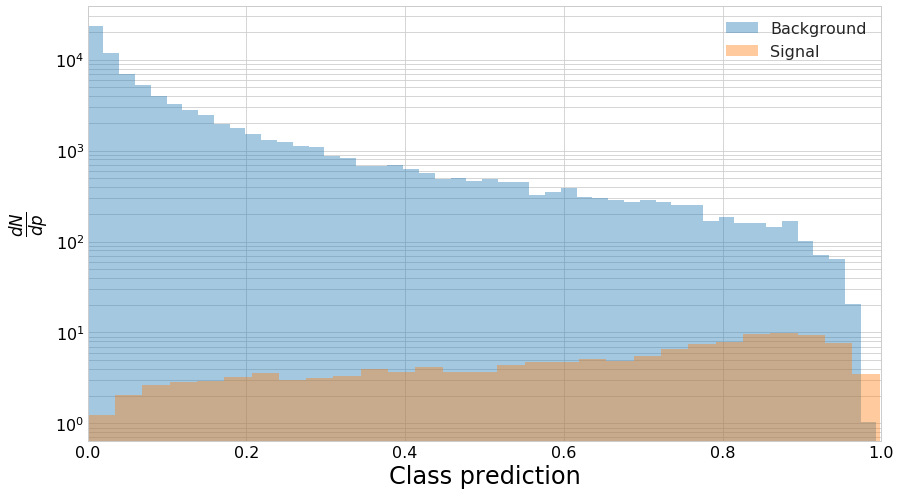

In [42]:
plot_binary_class_pred(val_df, wgt_name='gen_weight', density=False, log_y=True)

Mean cut at 0.8264602422714233 corresponds to AMS of 3.116363865758396
Maximum AMS for data is 3.250335886127936 at cut of 0.7749307751655579


/home/giles/anaconda3/envs/fastai/lib/python3.6/site-packages/seaborn/distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


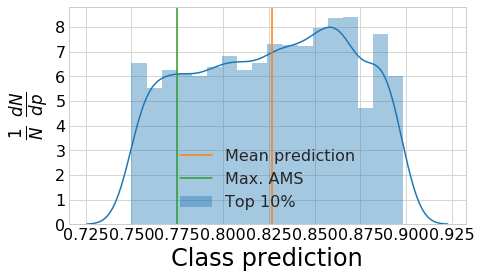

In [43]:
cut, smooth_ams, max_ams = binary_class_cut(val_df, top_perc=10, br=10, wgt_factor=250000/50000, min_pred=0.75)

## Test

In [44]:
test_df = pd.read_csv(IMG_PATH/'test.csv'); len(test_df); test_df.head()

,image_name,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_met_px,PRI_met_py,PRI_jet_subleading_px,PRI_jet_subleading_py,PRI_jet_subleading_pz,PRI_met_pt,PRI_jet_num,gen_target,gen_weight,private
0,0,83.603,68.288,60.537,22.237001,2.838,195.098,-1.993,2.986,5.644000,...,-31.984810,8.044772,-34.61359,13.721158,-84.77542,32.981,2.0,0,0.171749,1
1,1,149.232,83.593,83.268,1.604002,0.000,0.000,0.000,3.137,1.603999,...,-30.571934,-1.021707,0.00000,0.000000,0.00000,30.589,0.0,0,2.719791,1
2,2,175.897,89.769,99.229,34.115000,0.000,0.000,0.000,3.177,1.683000,...,-25.112593,0.266019,0.00000,0.000000,0.00000,25.114,1.0,0,1.466494,1
3,3,80.256,36.728,48.894,83.782000,1.205,285.153,0.078,1.965,148.636000,...,30.188456,35.507412,-66.92020,40.242070,-127.61574,46.606,3.0,0,0.549270,1
4,4,169.018,35.098,109.722,81.824000,0.000,0.000,0.000,3.038,22.123000,...,39.033920,30.988370,0.00000,0.000000,0.00000,49.839,1.0,0,1.382493,1


In [45]:
test_lst = ImageList.from_df(test_df, IMG_PATH/'images', folder='test', suffix='.png')

In [46]:
learn = load_learner(IMG_PATH/'images', test=test_lst)

In [47]:
%%time
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

CPU times: user 3h 11min 39s, sys: 5h 2min 51s, total: 8h 14min 30s
Wall time: 1h 5min 40s


In [48]:
test_df['pred'] = to_np(multiclass2binary(preds))

In [49]:
test_df.head()

,image_name,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_met_py,PRI_jet_subleading_px,PRI_jet_subleading_py,PRI_jet_subleading_pz,PRI_met_pt,PRI_jet_num,gen_target,gen_weight,private,pred
0,0,83.603,68.288,60.537,22.237001,2.838,195.098,-1.993,2.986,5.644000,...,8.044772,-34.61359,13.721158,-84.77542,32.981,2.0,0,0.171749,1,0.038848
1,1,149.232,83.593,83.268,1.604002,0.000,0.000,0.000,3.137,1.603999,...,-1.021707,0.00000,0.000000,0.00000,30.589,0.0,0,2.719791,1,0.051177
2,2,175.897,89.769,99.229,34.115000,0.000,0.000,0.000,3.177,1.683000,...,0.266019,0.00000,0.000000,0.00000,25.114,1.0,0,1.466494,1,0.119073
3,3,80.256,36.728,48.894,83.782000,1.205,285.153,0.078,1.965,148.636000,...,35.507412,-66.92020,40.242070,-127.61574,46.606,3.0,0,0.549270,1,0.072369
4,4,169.018,35.098,109.722,81.824000,0.000,0.000,0.000,3.038,22.123000,...,30.988370,0.00000,0.000000,0.00000,49.839,1.0,0,1.382493,1,0.401062


In [50]:
score_test_df(test_df, cut)

Public:Private AMS: 2.946943608687467 : 2.956856005526961


(2.946943608687467, 2.956856005526961)

In [51]:
score_test_df(test_df, 0.7749307751655579)

Public:Private AMS: 3.0013342291523237 : 3.0435461162976525


(3.0013342291523237, 3.0435461162976525)

In [52]:
test_df.to_csv('9_test.csv')

In [4]:
test_df = pd.read_csv('9_test.csv')

In [54]:
test_df.head()

,Unnamed: 0,image_name,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,...,PRI_met_py,PRI_jet_subleading_px,PRI_jet_subleading_py,PRI_jet_subleading_pz,PRI_met_pt,PRI_jet_num,gen_target,gen_weight,private,pred
0,0,0,83.603,68.288,60.537,22.237001,2.838,195.098,-1.993,2.986,...,8.044772,-34.61359,13.721158,-84.77542,32.981,2.0,0,0.171749,1,0.038848
1,1,1,149.232,83.593,83.268,1.604002,0.000,0.000,0.000,3.137,...,-1.021707,0.00000,0.000000,0.00000,30.589,0.0,0,2.719791,1,0.051177
2,2,2,175.897,89.769,99.229,34.115000,0.000,0.000,0.000,3.177,...,0.266019,0.00000,0.000000,0.00000,25.114,1.0,0,1.466494,1,0.119073
3,3,3,80.256,36.728,48.894,83.782000,1.205,285.153,0.078,1.965,...,35.507412,-66.92020,40.242070,-127.61574,46.606,3.0,0,0.549270,1,0.072369
4,4,4,169.018,35.098,109.722,81.824000,0.000,0.000,0.000,3.038,...,30.988370,0.00000,0.000000,0.00000,49.839,1.0,0,1.382493,1,0.401062


In [55]:
from lumin.evaluation.ams import *
from sklearn.model_selection import StratifiedKFold

In [56]:
ams_scan_quick(test_df[test_df.private==0], br=10), ams_scan_quick(test_df[test_df.private==1], br=10)

((3.0243965023275954, 0.7628221), (3.0472956765787877, 0.7718084))

In [59]:
from sklearn.model_selection import KFold

def subsample_score_test(df:pd.DataFrame, cut:Optional[float]=None):
    amss = pd.DataFrame(columns=['Public_AMS', 'Private_AMS', 'Public_Cut', 'Private_Cut'])
    skf = KFold(10, True, 0)
    folds = skf.split(df)
    for _, fold in folds:
        test_fold = test_df.iloc[fold]
        if cut is None:
            public_ams, public_cut = ams_scan_quick(test_fold[test_fold.private==0], br=10, wgt_factor=len(test_df[test_df.private==0])/len(test_fold[test_fold.private==0]))
            private_ams, private_cut = ams_scan_quick(test_fold[test_fold.private==1], br=10, wgt_factor=len(test_df[test_df.private==1])/len(test_fold[test_fold.private==1]))
        else:
            public_cut,private_cut = cut,cut 
            public_ams, private_ams = score_test_df(test_fold, cut, verbose=False,
                                                    public_wgt_factor=len(test_df[test_df.private==0])/len(test_fold[test_fold.private==0]),
                                                    private_wgt_factor=len(test_df[test_df.private==1])/len(test_fold[test_fold.private==1]))
        amss = amss.append({'Public_AMS':public_ams, 'Private_AMS':private_ams, 'Public_Cut':public_cut, 'Private_Cut':private_cut}, ignore_index=True)
    return amss

In [60]:
results = subsample_score_test(test_df); results

,Public_AMS,Private_AMS,Public_Cut,Private_Cut
0,3.409453,3.079089,0.966399,0.788617
1,3.199534,3.148017,0.774319,0.779425
2,3.670364,3.093383,0.909131,0.781462
3,2.998576,2.967872,0.764630,0.787894
4,4.861183,3.084118,0.959194,0.749511
5,2.945044,3.201477,0.640031,0.743790
6,2.814086,3.075017,0.727235,0.742081
7,3.460792,3.114461,0.969070,0.752193
8,3.501829,2.987994,0.761062,0.775693
9,3.410431,3.066176,0.792244,0.767900


In [61]:
results.describe()

,Public_AMS,Private_AMS,Public_Cut,Private_Cut
count,10.000000,10.000000,10.000000,10.000000
mean,3.427129,3.081761,0.826332,0.766857
std,0.574134,0.068305,0.115933,0.018343
min,2.814086,2.967872,0.640031,0.742081
25%,3.048815,3.068386,0.761954,0.750182
50%,3.409942,3.081603,0.783282,0.771796
75%,3.491570,3.109192,0.946678,0.780953
max,4.861183,3.201477,0.969070,0.788617
